<a href="https://colab.research.google.com/github/mekhanikaladvantage/vneural-pdes/blob/main/DeepRitz_jax_2dslit_poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#imports
!pip install optax
# !pip install --upgrade jax
# !pip install --upgrade jaxlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 6.5 MB/s eta 0:00:00


In [ ]:
from jax import jit, grad, vmap, value_and_grad
from jax import random, nn, jacfwd, jacrev
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import optax
import math

# JAX_DEBUG_NANS=True
JAX_DEBUG_NANS = False
from jax.config import config
# config.update("jax_debug_nans",True)
config.update("jax_debug_nans",False)
config.parse_flags_with_absl()

#set 64 bit precision
# JAX_ENABLE_X64=True
JAX_ENABLE_X64=False

%xmode context
# %xmode verbose

Exception reporting mode: Context


In [ ]:
key, subkey = random.split(random.PRNGKey(0))

Hyperparameters and Model
=============

In [ ]:
#set hyperparameters
# THIS CELL MUST BE RUN THE RESET THE PARAMETERS OF THE NETWORK

# this creates random parameters for the weights and biases of a given node
def random_layer_params(m:int,n:int,key, scale = 2.0e-1) -> tuple:
    w_key, b_key = random.split(key)
    # return scale * random.normal(w_key,(n,m)), scale * random.normal(b_key,(n,1))
    minval = -6/(jnp.sqrt(m + n))
    # minval = 1
    maxval = -1*minval
    # maxval = 2
    w = scale * random.uniform(w_key,(n,m),minval = minval,maxval = maxval)
    b = scale * random.uniform(b_key,(n,),minval = minval,maxval = maxval)
    return w,b 

# this should initalize nodes
def init_network_params(sizes:list,key) -> list:
    keys = random.split(key, len(sizes))
    return [random_layer_params(m,n,k) for m,n,k in zip(sizes[:-1],sizes[1:],keys)]


hypers = dict()
hypers["d"] = 2
hypers["m"] = 10
hypers["step size"] = 1e-03
hypers["num epochs"] = 50000
# hypers["num epochs"] = int(1e5)
hypers["batch size"] = 256
hypers["boundary size"] = 256
hypers["beta"] = 500.0

# layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],1]
#experiment architecture:
#3 blocks
layer_sizes = [hypers["d"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],hypers["m"],1]

# params = init_network_params(layer_sizes,random.PRNGKey(0))
params = init_network_params(layer_sizes,subkey)


key, subkey = random.split(key) #this enables us to not fix the initial parameters

optimizer = optax.adam(learning_rate = hypers["step size"])



In [ ]:
from jaxlib.xla_extension import DeviceArray
compiled_celu = jit(nn.celu)
compiled_softplus = jit(nn.softplus)


def relu(x) -> np.float32:
  return jnp.maximum(0,x**3)

def model(params:list,x:DeviceArray) -> np.float32:
    # print("shape of ijnput is {}".format(x.shape))
    '''
    params: list of weight, bias tuples. 
    x: Input vector. Should be shape (2,)
    x[0] is x coord, x[1] is y coord.
    '''

    w,b = params[0]
    # activations = nn.gelu(jnp.dot(w,x) + b) #lin transform of data to match net width
    # activations = compiled_celu(jnp.dot(w,x) + b)
    # activations = jnp.tanh((jnp.dot(w,x) + b))
    # output = jnp.add(jnp.dot(w,x),b)
    output = jnp.dot(w,x) + b
    activations = relu(output)
    # activations = nn.softplus(jnp.dot(w,x) + b)

    # print("shape of activations is {}".format(activations.shape))
    residual = activations #will be used for skip connection, needs right dim
    #evenness counter
    layer_number = 1
    i = 0
    # print("activations before lin transform is {}".format(activations))
    
    for w,b in params[1:-1]: #first and last params are for linear transformation
        # output = jnp.add(jnp.dot(w,activations),b)
        output = jnp.dot(w,activations) + b
        # print("output of transform before relu is {}".format(output))
        
        # activations = relu(output)
        # activations = compiled_celu(output)
        # activations = nn.gelu(output)
        # activations = nn.softplus(output)
        # activations = jnp.tanh(output)
        activations = relu(output)
        
        if i%2 == 0: #only have skip connection on even blocks
            # print(f"adding skip connection after block {i}")
            activations += residual #add skip connection
            residual = activations #update residual
            # print(f'skip after layer {layer_number}')
        layer_number += 1
        i += 1
        # # print("activations after transform is {}".format(activations))
        
    final_w,final_b = params[-1] 
    # final_w,final_b = params[-1] 
    # final transform to obtain scalar
    # logits = jnp.add(jnp.dot(final_w,activations),final_b)
    logits = jnp.dot(final_w,activations) + final_b

    return logits[0]


    #######

batched_model = vmap(model,in_axes=(None,0)) #maps dim(2,128) -> dim(128)

In [ ]:
# model debugging
x = jnp.array([1.0,0.5])
out = model(params,x) # 0.004663214
print(out)

# xs = jnp.ones(shape=(10,))
# ys = jnp.zeros(shape=(10,))
# vector = jnp.stack((xs,ys),axis=1)
# # print(vector)
# outs = batched_model(params,vector)
# print(outs)

# out = jnp.nextafter(1.,jnp.inf)
# print(out)

# print(params)

0.31798396


In [ ]:
# from jaxlib.xla_extension.jax_jit import device_put

# #batching cell
# import time

# bdy_start_time = time.time()


# # int_x_range = jnp.linspace(-1,1,num=batch_size)
# int_x_range = jnp.linspace(-1 + 1e-10,1 - 1e-10,num=2*batch_size)
# x_range = jnp.linspace(-1,1,num=1000)
# pos_x_range = jnp.linspace(0,1,num=500)
# #domain is top, bottom, left, right
# top = jnp.transpose(jnp.array([[x,1.] for x in x_range]))
# bottom = jnp.transpose(jnp.array([[x,-1.] for x in x_range]))
# left = jnp.transpose(jnp.array([[-1.,x] for x in x_range]))
# right = jnp.transpose(jnp.array([[1.,x] for x in x_range]))
# slit = jnp.transpose(jnp.array([[x,0.] for x in pos_x_range]))

# # boundary = jnp.concatenate((top,bottom,left,right),axis=1)
# boundary = jnp.concatenate((top,bottom,left,right,slit),axis=1)
# bdy_get_time = time.time() - bdy_start_time
# print(f'Generating boundary costs {bdy_get_time} seconds.')

# def get_batch(batch_size:int,key:DeviceArray) -> DeviceArray:
#     # batch_matrix = random.choice(key,x_range,(batch_size,d))
#     batch_matrix = random.choice(key,int_x_range,(d,batch_size))
#     batch_matrix = device_put(batch_matrix)
#     return batch_matrix

# # def get_boundary_batch(batch_size:int,key:DeviceArray) -> DeviceArray:
# #     # noise_key, key = random.split(key)
# #     # noise = 1e-2* random.normal(noise_key,shape=(d,jnp.size(boundary,axis=1)))
# #     # # print(f'shape of noise vector is {noise.shape}')
# #     # # print(f'some noise output is {noise[:,:3]}')
# #     # noisy_boundary = jnp.add(boundary,noise)
    
# #     boundaryBatch = random.choice(key,boundary,shape=(batch_size,),axis=1,replace=True)
    
# #     #IDEA: sample points from each portion of boundary instead of just in general
# #     # split_size = int(jnp.ceil(batch_size/4))
# #     # # print(split_size)
# #     # keys = random.split(key,4)
# #     # top_sample = random.choice(key,top,shape=(split_size,),axis=1)
# #     # bottom_sample = random.choice(key,bottom,shape=(split_size,),axis=1)
# #     # left_sample = random.choice(key,left,shape=(split_size,),axis=1)
# #     # right_sample = random.choice(key,right,shape=(split_size,),axis=1)
# #     # boundaryBatch = jnp.concatenate((top_sample,bottom_sample,left_sample,right_sample),axis=1)
    
# #     # boundaryBatch = np.transpose(random.choice(key,noisy_boundary,(batch_size,)))
# #     # print("shape of boundaryBatch is {}".format(boundaryBatch.shape))
# #     return boundaryBatch

# def get_boundary_batch(batch_size:int,key:DeviceArray,section:DeviceArray) -> DeviceArray:
#   return random.choice(key=key,a=section,shape=(batch_size,),axis=1)

Batching
===========

In [ ]:
key, subkey = random.split(random.PRNGKey(0))
#  #need static argums batch dim size

nudge = jnp.finfo(np.float32).tiny
print(nudge)

#sampling overhaul: I'm still discretizing stuff. I don't want to discretize anything
# I believe I should sample uniformly for now
def get_batch(batch_size:int,key:DeviceArray) -> DeviceArray:
  return random.uniform(key,shape = (batch_size,hypers["d"]),minval=jnp.nextafter(-1,jnp.inf),maxval=1)
  # return random.uniform(key,shape = (batch_size,d),minval=-1+nudge,maxval=1)
  # nextafter gives me the next biggest floating point number  
  # keys = random.split(key,num=2)
  # # trying to exclude 0 
  # top_half = random.uniform(key,shape=(int(batch_size/2),d),minval=jnp.nextafter(-1,jnp.inf),maxval=0)
  # bottom_half = random.uniform(key,shape=(int(batch_size/2),d),minval=jnp.nextafter(0,jnp.inf),maxval=1)
  # return jnp.concatenate((top_half,bottom_half),axis=0)


ones = jnp.ones(shape=(hypers["boundary size"],))
slit_size = int(hypers["boundary size"]/2)
zeros = jnp.zeros(shape=(slit_size,))


def get_boundary_batch(bdy_batch_size:int,key:DeviceArray) -> DeviceArray:
  keys = random.split(key,num=5)

  high_end = jnp.nextafter(1,jnp.inf) # to include 1 in sample
  # high_end = 1 + nudge

  top_sample = random.uniform(keys[0],shape=(bdy_batch_size,),minval=-1,maxval=high_end)
  # print(top_sample.shape)
  top = jnp.stack((top_sample,ones),axis=1)

  right_sample = random.uniform(keys[1],shape=(bdy_batch_size,),minval=-1,maxval=high_end)
  right = jnp.stack((ones,right_sample),axis=1)

  bot_sample = random.uniform(keys[2],shape=(bdy_batch_size,),minval=-1,maxval=high_end)
  bot = jnp.stack((bot_sample,-1*ones),axis=1)

  left_sample = random.uniform(keys[3],shape=(bdy_batch_size,),minval=-1,maxval=high_end)
  left = jnp.stack((-1*ones,left_sample),axis=1)

  slit_sample = random.uniform(keys[4],shape=(slit_size,),minval=0,maxval=1)
  slit = jnp.stack((slit_sample,zeros),axis=1)

  boundary = jnp.concatenate((top,right,bot,left,slit),axis=0)
  # boundary = jnp.concatenate((top,right,bot,left),axis=0)

  # all_bdy_xs = jnp.concatenate((top_sample,ones,bot_sample,-1*ones,slit_sample))
  # all_bdy_ys = jnp.concatenate((ones,right_sample,-1*ones,left_sample,zeros))
  return boundary

  # return (all_bdy_xs,all_bdy_ys)

# ones = jnp.ones(shape=(4,))
# zeros = jnp.zeros(shape=(4),)
boundary = get_boundary_batch(hypers["boundary size"],subkey)
# interior = get_batch(4,subkey)
# print(interior)
print(boundary)
# print(f'shape of boundary is {boundary.shape}')

1.1754944e-38
[[ 0.53696775  1.        ]
 [-0.40355515  1.        ]
 [ 0.34293818  1.        ]
 ...
 [ 0.18528831  0.        ]
 [ 0.12491786  0.        ]
 [ 0.7791774   0.        ]]


In [ ]:
# from optax._src.base import OptState
# from chex._src.pytypes import Device
# from jax._src.random import KeyArray

# # the nans are coming from the square root in the norm! sqrt(0) is 
# # not differentiable and so will return a nan. 

# #attempt 1 to bypass: custom norm function since I only need squared norm
# # this bypasses ever computing the square root and so should be smooth!
# def norm_squared(x:DeviceArray) -> np.float32:
#   #x should be an column vector
#   return jnp.sum(jnp.real(x*jnp.conj(x)))

# def smooth_abs(x:np.float32, eps = 1e-10)-> np.float32:
#     return jnp.sqrt(x**2 + eps)

# def loss_fn(params:list,x:DeviceArray,y:DeviceArray) -> np.float32: #write as map from dim(2) -> dim(1)

#     dudx = grad(model,1)(params,x,y)
#     # loss = jnp.add(0.5*jnp.linalg.norm(dudx,2)**2, -1*model(params,x))
#     # loss = jnp.add(0.5*jnp.linalg.norm(dudx_safe,2)**2, -1*model(params,x))
    
#     loss = jnp.add(0.5*(dudx*dudx),model(params,x))
#     # loss = smooth_abs(jnp.add(0.5*norm_squared(dudx),-model(params,x)))
    
#     # currently f = 1 is hardcoded.
#     return loss


# def boundary_loss(params:list,x:DeviceArray) -> np.float32: #map from dim(2) -> dim(1)
#     loss = (model(params,x))**2
  
#     # loss = (model(params,x) - bdy_exact(x))**2

#     # dudx = grad(model,1)(params,x)
    
#     # loss = jnp.add(jnp.add(0.5*norm_squared(dudx),-model(params,x)),model(params,x)**2)
#     # loss = beta*jnp.linalg.norm(model(params,x))**2
#     # loss = beta*(model(params,x)**2)
#     # loss = (0.5*(jnp.linalg.norm(grad(model, 1)(params,x))**2) - model(params,x)) + beta*(model(params,x))**2
#     return loss

# #batch model and loss. Want to map (2,128) -> (dim)
# # batched_model = vmap(model,in_axes=(None,1)) #maps dim(2,128) -> dim(128)
# batched_loss = vmap(loss_fn,in_axes=(None,1)) #maps dim(2,128) -> dim(128)
# batched_boundary_loss = vmap(boundary_loss,in_axes=(None,1)) #maps dim(2,128) -> dim(128)


# def avg_batch_loss(params:list,batch:DeviceArray) -> np.float32:
#     # print(f'some batch_loss output: {batched_loss[:3]}')
#     return jnp.mean(a=batched_loss(params,batch))

# def avg_boundary_batch_loss(params:list,boundaryBatch:DeviceArray) -> np.float32:
    
#     # return jnp.mean(batched_boundary_loss(params,boundaryBatch))
#     return beta*jnp.mean(batched_boundary_loss(params,boundaryBatch))
#     # return jnp.mean(a=batched_boundary_loss(params,boundaryBatch))

#     # just for funsies
#     # return norm_squared(batched_model(params,boundaryBatch))

# def avg_total_loss(params,batch,boundaryBatch):
    
#     #verbose debugging block

#     int_loss = avg_batch_loss(params,batch)
#     bdy_loss = avg_boundary_batch_loss(params,boundaryBatch)

#     # this should cause me to learn the zero function!!!!
#     # int_loss = avg_boundary_batch_loss(params,batch)

#     # average of each section attempt
    

#     return jnp.add(int_loss,bdy_loss)

#     # return jnp.add(avg_batch_loss(params,batch),avg_boundary_batch_loss(params,boundaryBatch))

# # def avg_total_loss(params:list,batch:DeviceArray,key:KeyArray) -> np.float32:
# #   flow_loss = avg_batch_loss(params=params,batch=batch)

# #   # keys = random.split(key,num=5)
  
# #   # top_sample = get_boundary_batch(batch_size=bdy_batch_size,key = keys[0],section=top)
# #   # top_loss = avg_boundary_batch_loss(params=params,boundaryBatch = top_sample)
  
# #   # bottom_sample = get_boundary_batch(batch_size=bdy_batch_size,key = keys[1],section=bottom)
# #   # bottom_loss = avg_boundary_batch_loss(params=params,boundaryBatch = bottom_sample)
  
# #   # right_sample = get_boundary_batch(batch_size=bdy_batch_size,key = keys[2],section=right)
# #   # right_loss = avg_boundary_batch_loss(params=params,boundaryBatch = right_sample)

# #   # left_sample = get_boundary_batch(batch_size=bdy_batch_size,key = keys[3],section=left)
# #   # left_loss = avg_boundary_batch_loss(params=params,boundaryBatch = left_sample)
  

# #   # #slit
# #   # slit_sample = get_boundary_batch(batch_size=bdy_batch_size,key = keys[4],section=slit)
# #   # slit_loss = avg_boundary_batch_loss(params=params,boundaryBatch = slit_sample)


# #   # bdy_loss = beta*jnp.sum(jnp.array([top_loss,bottom_loss,left_loss,right_loss]))
# #   bdy_loss = beta*jnp.sum(jnp.array([top_loss,bottom_loss,left_loss,right_loss,slit_loss]))

# #   return jnp.add(flow_loss,bdy_loss)

# def update(params:list,opt_state:OptState,key:KeyArray):
#     keys = random.split(key)
#     batch = get_batch(batch_size,keys[0])
#     boundary_batch = get_boundary_batch(bdy_batch_size,keys[1])
#     int_loss = avg_batch_loss(params,batch)
    
#     total_loss,grads = value_and_grad(avg_total_loss)(params,batch,boundary_batch)
#     # grads = [a + b for a,b in zip(int_grads,bdy_grads)] raises error in updating moments
    
#     bdy_loss = jnp.subtract(total_loss,int_loss)

#     #Adam
#     updates,opt_state = optimizer.update(grads,opt_state,params)
#     params = optax.apply_updates(params,updates)
#     # return params, opt_state, loss
#     return params,opt_state,int_loss,bdy_loss
#     # return params,opt_state,int_loss,bdy_loss,max_eigen
# #end    
    
# compiled_update = jit(update)

# # def update(params,intBatch,bdyBatch):
# #     joinedBatch = jnp.concatenate(intBatch,bdyBatch)
# #     grads = grad(avg_batch_loss,static_argnums = 1)(params,joinedBatch)
# #     return [(w - (step_size * dw), b - (step_size*db)) for (w,b),(dw,db) in zip(params,grads)] #update all params

Loss and Update
======

In [ ]:
'''
loss and update block
'''

from optax._src.base import OptState
from chex._src.pytypes import Device
from jax._src.random import KeyArray

def smooth_abs(x:np.float32, eps = 1e-10)-> np.float32:
    return jnp.sqrt(x**2 + eps)


def flow_loss_fn(params:list,x:DeviceArray) -> np.float32:
  '''
  flow loss calculated on 1 2D sample in order to have scalar output.
  The scalar output is necessary for autograd to work.
  '''
  dudx = grad(model,argnums=1)(params,x) # compute gradient wrt sample
  # print(f'shape of gradient is {dudx.shape}')
  # print(f'gradient is {dudx}')
  # print(f'gradient squared is {dudx*dudx}')
  return 0.5*(jnp.sum(dudx*dudx)) - model(params,x)
  

flow_loss_vector = vmap(flow_loss_fn,in_axes=(None,0)) 

def loss_fn(params:list,key:KeyArray) -> np.float32:
# def loss_fn(params:list,interior_sample,boundary_sample):
  '''
  this function samples data and calculates the loss.
  Please note that this function must be differentiable.
  The loss consists of two parts, an flow loss given by the energy,
  and a boundary loss to enforce boundary conditions. 
  '''
  # generate data
  keys = random.split(key,num=2)
  interior_sample = get_batch(hypers["batch size"],keys[0])
  boundary_sample = get_boundary_batch(hypers["boundary size"],keys[1])
  interior_sample.at[:,1].set(jnp.setdiff1d(interior_sample[:,1],boundary_sample[:,1],size=256,fill_value = 1e-1))


  #calculate flow loss
  flow_output = flow_loss_vector(params,interior_sample)
  flow_loss = jnp.mean(flow_output) #+ 0.4
  # the + 0.6 is to avoid negatives and keep close to 0.

  #calculate boundary loss
  # bdy_loss = beta*jnp.mean(batched_model(params,boundary_sample)*batched_model(params,boundary_sample))
  bdy_output = batched_model(params,boundary_sample)
  bdy_loss = hypers["beta"]*jnp.mean((bdy_output*bdy_output))

  return jnp.add(flow_loss,bdy_loss)

def update(params:list,opt_state:OptState,key:KeyArray):
# def update(params:list,opt_state:OptState,interior_sample,boundary_sample):
  '''
  This calculates the parameter updates using the ADAM algorithm,
  as implemented in optax.
  '''

  loss,grads = value_and_grad(loss_fn,argnums=0)(params,key)
  # loss,grads = value_and_grad(loss_fn,argnums=0)(params,interior_sample,boundary_sample)

  updates,opt_state = optimizer.update(grads,opt_state,params)
  params = optax.apply_updates(params,updates)

  return params,opt_state,loss

#jit update for moar speed
compiled_update = jit(update)

In [ ]:
'''
Error Analysis
'''
# problem is slightly different for analysis

def bdy_exact(x:DeviceArray) -> np.float32:
  radius = jnp.sqrt((x[0]**2) + (x[1]**2))
  theta = jnp.arctan2(x[1],x[0]) #need arctan(y/x)
  # theta = jnp.arctan(x[:,1]/x[:,0])
  return jnp.abs(jnp.sqrt(radius)*jnp.sin(0.5*theta))
# the abs here is not actually part of the paper, 
# but I found it necessary since the problem as given in the paper is nonsense.

bdy_exact_vector = vmap(bdy_exact,in_axes=0)

def error_flow_loss_fn(params:list,x:DeviceArray) -> np.float32:
  '''
  flow loss calculated on 1 2D sample in order to have scalar output.
  The scalar output is necessary for autograd to work.
  '''
  dudx = grad(model,argnums=1)(params,x) # compute gradient wrt sample
  # print(f'shape of gradient is {dudx.shape}')
  # print(f'gradient is {dudx}')
  # print(f'gradient squared is {dudx*dudx}')
  return 0.5*(jnp.sum(dudx*dudx))
  
error_flow_loss_vector = vmap(error_flow_loss_fn,in_axes=(None,0)) 
 

def error_loss_fn(params:list,key:KeyArray) -> np.float32:
# def loss_fn(params:list,interior_sample,boundary_sample):
  '''
  this function samples data and calculates the loss.
  Please note that this function must be differentiable.
  The loss consists of two parts, an flow loss given by the energy,
  and a boundary loss to enforce boundary conditions. 
  '''
  # generate data
  keys = random.split(key,num=2)
  interior_sample = get_batch(hypers["batch size"],keys[0])
  boundary_sample = get_boundary_batch(hypers["boundary size"],keys[1])
  interior_sample.at[:,1].set(jnp.setdiff1d(interior_sample[:,1],boundary_sample[:,1],size=1024,fill_value = 1e-1))


  #calculate flow loss
  error_flow_output = error_flow_loss_vector(params,interior_sample)
  error_flow_loss = jnp.mean(error_flow_output) #+ 0.4
  # the + 0.6 is to avoid negatives and keep close to 0.

  #calculate boundary loss
  # bdy_loss = beta*jnp.mean(batched_model(params,boundary_sample)*batched_model(params,boundary_sample))
  bdy_output = batched_model(params,boundary_sample)
  exact_output = bdy_exact_vector(boundary_sample)
  bdy_diff = bdy_output - exact_output
  error_bdy_loss = hypers["beta"]*jnp.mean(bdy_diff*bdy_diff)

  return jnp.add(error_flow_loss,error_bdy_loss)

def error_update(params:list,opt_state:OptState,key:KeyArray):
# def update(params:list,opt_state:OptState,interior_sample,boundary_sample):
  '''
  This calculates the parameter updates using the ADAM algorithm,
  as implemented in optax.
  '''

  loss,grads = value_and_grad(error_loss_fn,argnums=0)(params,key)
  # loss,grads = value_and_grad(loss_fn,argnums=0)(params,interior_sample,boundary_sample)

  updates,opt_state = optimizer.update(grads,opt_state,params)
  params = optax.apply_updates(params,updates)

  return params,opt_state,loss

#jit update for moar speed
compiled_error_update = jit(error_update)




In [ ]:
# model debugging
# print(params[0])

x = jnp.array([1.0, 0.75])
out_test = flow_loss_fn(params,x)
# out_test = model(params,x)
print(out_test)

# key = random.PRNGKey(2)
# loss = loss_fn(params,key)
# print(loss)

glue = jnp.ones(shape=(3,1))
gluee = jnp.ones(shape = (3,))
# print(glue)
# print(gluee + gluee)
foo = jnp.reshape(jnp.arange(0,9),(3,3))
bar = jnp.dot(foo,gluee)
# print(bar + gluee)
# print(bar + glue)
baz = jnp.dot(foo,(bar+glue))
# print(baz)

byoom = jnp.dot(foo,(bar+gluee))
# print(byoom)

input = jnp.array([0.5,0])
test = bdy_exact(input)
print(test)

-0.32558513
0.0


For more notes on the norm autograd issue, see:
https://github.com/google/jax/issues/6484
https://github.com/google/jax/pull/2447
https://colab.research.google.com/github/google/jax/blob/master/docs/notebooks/Custom_derivative_rules_for_Python_code.ipynb
https://github.com/google/jax/issues/1052#issuecomment-514083352
https://github.com/google/jax/issues/3058

In [ ]:
key,bd_key = random.split(random.PRNGKey(41),num=2)

In [ ]:

keys = random.split(bd_key,num=2)
bb = get_boundary_batch(hypers["boundary size"],keys[0])
ib = get_batch(hypers["batch size"],keys[1])
ib.at[:,1].set(jnp.setdiff1d(ib[:,1],bb[:,1],size=256,fill_value = 1e-1))
# print(0.0 in ib[:,1])
print(any([jnp.isclose(x,0.0) for x in ib[:,1]]))
# sample = np.concatenate((bb,ib),axis=0)

# plt.scatter(sample[:,0],sample[:,1])

# indicator_output = [indicator(x,sample) for x in sample]
# print(sample)

num_of_samples = 150
x_range = jnp.linspace(-1,1,num=num_of_samples) #inclusive on inputs and outputs
[Xs,Ys] = jnp.meshgrid(x_range,x_range)



False


Training Block
=========
Next two cells are for resetting the random key and parameters. This is for reproducibility.

Afterwards is the training block.

In [ ]:
#reset key
key, train_key = random.split(random.PRNGKey(0))
params = init_network_params(layer_sizes,train_key)

---------------
Epoch 0 in 3.08 additional seconds
Flow loss is 0.0010730886133387685
Boundary loss is 38.80796813964844
Total loss is 39.15773010253906


<Figure size 432x288 with 0 Axes>

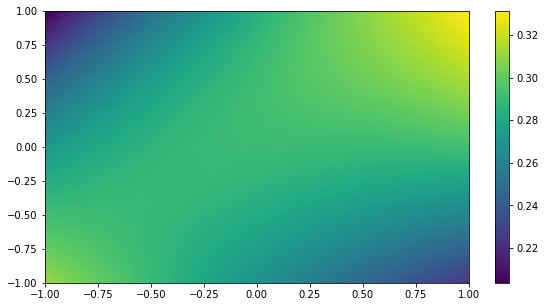

---------------
Epoch 1000 in 4.90 additional seconds
Flow loss is 8.298407192341983e-05
Boundary loss is 0.0014036918291822076
Total loss is -0.002150709740817547
---------------
Epoch 2000 in 1.25 additional seconds
Flow loss is 0.00028657089569605887
Boundary loss is 0.0014537355164065957
Total loss is -0.003631196217611432
---------------
Epoch 3000 in 1.23 additional seconds
Flow loss is 0.0008604200556874275
Boundary loss is 0.001828789827413857
Total loss is -0.0072237649001181126
---------------
Epoch 4000 in 1.22 additional seconds
Flow loss is 0.002975043375045061
Boundary loss is 0.003698216052725911
Total loss is -0.010438990779221058
---------------
Epoch 5000 in 1.23 additional seconds
Flow loss is 0.015643535181879997
Boundary loss is 0.005534319672733545
Total loss is -0.026204558089375496


<Figure size 432x288 with 0 Axes>

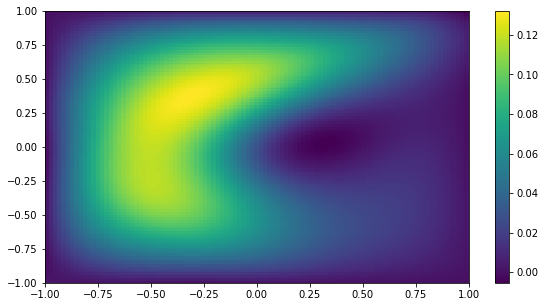

---------------
Epoch 6000 in 3.69 additional seconds
Flow loss is 0.02156718075275421
Boundary loss is 0.005028792656958103
Total loss is -0.021618235856294632
---------------
Epoch 7000 in 1.49 additional seconds
Flow loss is 0.022697320207953453
Boundary loss is 0.004041016101837158
Total loss is -0.020994504913687706
---------------
Epoch 8000 in 1.56 additional seconds
Flow loss is 0.022443342953920364
Boundary loss is 0.005221794359385967
Total loss is -0.023628737777471542
---------------
Epoch 9000 in 1.23 additional seconds
Flow loss is 0.022363444790244102
Boundary loss is 0.005741718225181103
Total loss is -0.02802213281393051
---------------
Epoch 10000 in 1.23 additional seconds
Flow loss is 0.024815691635012627
Boundary loss is 0.004047363065183163
Total loss is -0.029434483498334885


<Figure size 432x288 with 0 Axes>

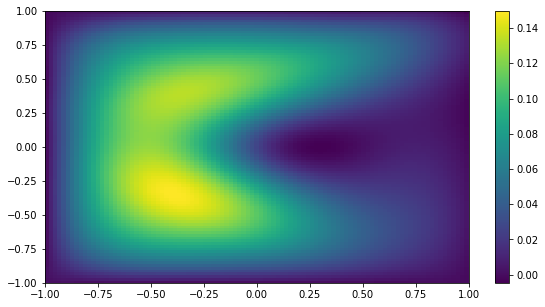

---------------
Epoch 11000 in 3.68 additional seconds
Flow loss is 0.02364272251725197
Boundary loss is 0.004743815399706364
Total loss is -0.025408094748854637
---------------
Epoch 12000 in 1.23 additional seconds
Flow loss is 0.02372918277978897
Boundary loss is 0.004391130059957504
Total loss is -0.02963383123278618
---------------
Epoch 13000 in 1.25 additional seconds
Flow loss is 0.024273421615362167
Boundary loss is 0.004706214182078838
Total loss is -0.035110097378492355
---------------
Epoch 14000 in 1.58 additional seconds
Flow loss is 0.022941671311855316
Boundary loss is 0.004253083374351263
Total loss is -0.028326621279120445
---------------
Epoch 15000 in 1.56 additional seconds
Flow loss is 0.028415068984031677
Boundary loss is 0.004272605758160353
Total loss is -0.02563944086432457


<Figure size 432x288 with 0 Axes>

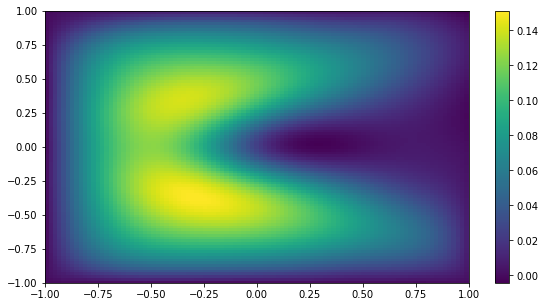

---------------
Epoch 16000 in 4.41 additional seconds
Flow loss is 0.030286502093076706
Boundary loss is 0.0033210499677807093
Total loss is -0.026974812150001526
---------------
Epoch 17000 in 1.23 additional seconds
Flow loss is 0.026489028707146645
Boundary loss is 0.002660796046257019
Total loss is -0.03363931179046631
---------------
Epoch 18000 in 1.24 additional seconds
Flow loss is 0.027279535308480263
Boundary loss is 0.0037792997900396585
Total loss is -0.037672340869903564
---------------
Epoch 19000 in 1.23 additional seconds
Flow loss is 0.03212073817849159
Boundary loss is 0.002927466295659542
Total loss is -0.0267799012362957
---------------
Epoch 20000 in 1.35 additional seconds
Flow loss is 0.029373692348599434
Boundary loss is 0.0035623263102024794
Total loss is -0.032355111092329025


<Figure size 432x288 with 0 Axes>

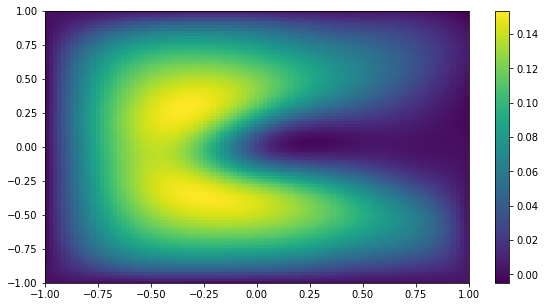

---------------
Epoch 21000 in 4.19 additional seconds
Flow loss is 0.030181583017110825
Boundary loss is 0.0033782031387090683
Total loss is -0.03184935078024864
---------------
Epoch 22000 in 1.27 additional seconds
Flow loss is 0.0304870568215847
Boundary loss is 0.002013641409575939
Total loss is -0.03236399590969086
---------------
Epoch 23000 in 1.27 additional seconds
Flow loss is 0.03291487693786621
Boundary loss is 0.003127547912299633
Total loss is -0.026296086609363556
---------------
Epoch 24000 in 1.27 additional seconds
Flow loss is 0.025070950388908386
Boundary loss is 0.0022454180289059877
Total loss is -0.035945843905210495
---------------
Epoch 25000 in 1.26 additional seconds
Flow loss is 0.03434762731194496
Boundary loss is 0.0024603568017482758
Total loss is -0.029188677668571472


<Figure size 432x288 with 0 Axes>

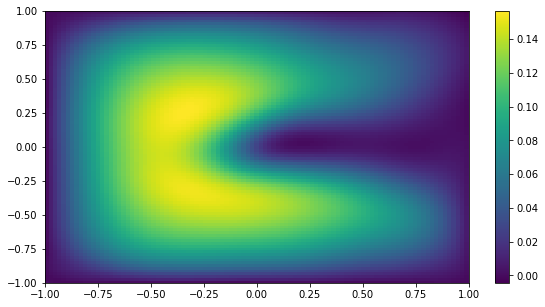

---------------
Epoch 26000 in 5.72 additional seconds
Flow loss is 0.027593916282057762
Boundary loss is 0.0029782697092741728
Total loss is -0.03592241182923317
---------------
Epoch 27000 in 1.29 additional seconds
Flow loss is 0.03102579526603222
Boundary loss is 0.0014602153096348047
Total loss is -0.03802606463432312
---------------
Epoch 28000 in 1.27 additional seconds
Flow loss is 0.030166182667016983
Boundary loss is 0.001349994563497603
Total loss is -0.04116145893931389
---------------
Epoch 29000 in 1.25 additional seconds
Flow loss is 0.03278938680887222
Boundary loss is 0.0037923413328826427
Total loss is -0.03614998608827591
---------------
Epoch 30000 in 1.30 additional seconds
Flow loss is 0.030732974410057068
Boundary loss is 0.002782377414405346
Total loss is -0.03979279845952988


<Figure size 432x288 with 0 Axes>

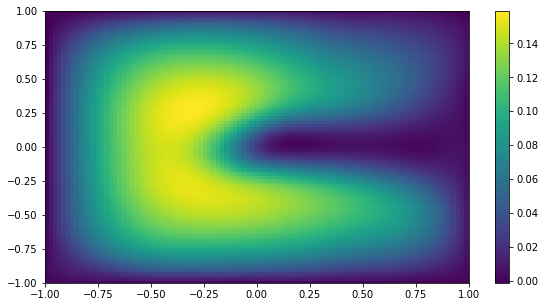

---------------
Epoch 31000 in 3.65 additional seconds
Flow loss is 0.03437945246696472
Boundary loss is 0.0020716118160635233
Total loss is -0.03299762308597565
---------------
Epoch 32000 in 1.67 additional seconds
Flow loss is 0.03222186118364334
Boundary loss is 0.0015260305954143405
Total loss is -0.03801869601011276
---------------
Epoch 33000 in 1.41 additional seconds
Flow loss is 0.03354747220873833
Boundary loss is 0.003926456440240145
Total loss is -0.03194960206747055
---------------
Epoch 34000 in 1.23 additional seconds
Flow loss is 0.03636655956506729
Boundary loss is 0.0011815231991931796
Total loss is -0.035060495138168335
---------------
Epoch 35000 in 1.22 additional seconds
Flow loss is 0.033568739891052246
Boundary loss is 0.0009622304933145642
Total loss is -0.03951813280582428


<Figure size 432x288 with 0 Axes>

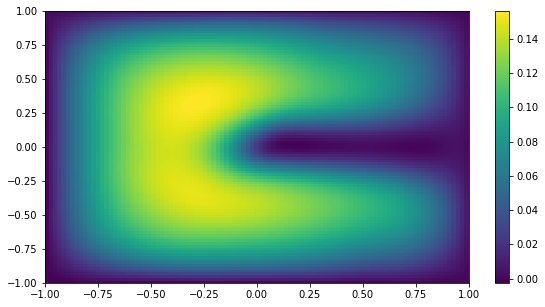

---------------
Epoch 36000 in 3.58 additional seconds
Flow loss is 0.034400634467601776
Boundary loss is 0.0011730415280908346
Total loss is -0.03972131386399269
---------------
Epoch 37000 in 1.24 additional seconds
Flow loss is 0.033371832221746445
Boundary loss is 0.00198362092487514
Total loss is -0.04165127873420715
---------------
Epoch 38000 in 1.25 additional seconds
Flow loss is 0.03630298376083374
Boundary loss is 0.0018079394940286875
Total loss is -0.03181471303105354
---------------
Epoch 39000 in 1.65 additional seconds
Flow loss is 0.03551913797855377
Boundary loss is 0.00185969821177423
Total loss is -0.03734290972352028
---------------
Epoch 40000 in 1.50 additional seconds
Flow loss is 0.037271738052368164
Boundary loss is 0.0013493194710463285
Total loss is -0.03112924098968506


<Figure size 432x288 with 0 Axes>

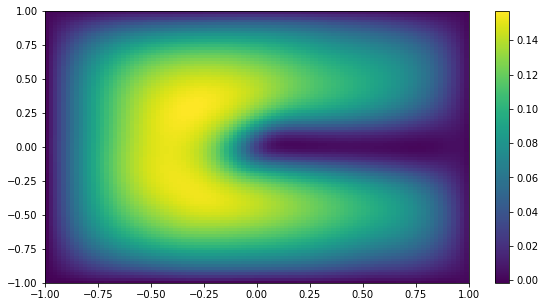

---------------
Epoch 41000 in 3.64 additional seconds
Flow loss is 0.036029279232025146
Boundary loss is 0.0019145127153024077
Total loss is -0.03434428945183754
---------------
Epoch 42000 in 1.26 additional seconds
Flow loss is 0.03317693620920181
Boundary loss is 0.0012738764053210616
Total loss is -0.04667152464389801
---------------
Epoch 43000 in 1.25 additional seconds
Flow loss is 0.03868134692311287
Boundary loss is 0.0016232203925028443
Total loss is -0.03437042608857155
---------------
Epoch 44000 in 1.28 additional seconds
Flow loss is 0.03609221801161766
Boundary loss is 0.0012793841306120157
Total loss is -0.03969482704997063
---------------
Epoch 45000 in 1.25 additional seconds
Flow loss is 0.03698107227683067
Boundary loss is 0.002265708986669779
Total loss is -0.03368891403079033


<Figure size 432x288 with 0 Axes>

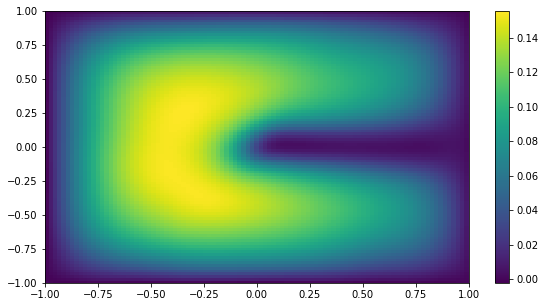

---------------
Epoch 46000 in 4.27 additional seconds
Flow loss is 0.032170556485652924
Boundary loss is 0.0018310768064111471
Total loss is -0.045952849090099335
---------------
Epoch 47000 in 1.27 additional seconds
Flow loss is 0.03757404908537865
Boundary loss is 0.0014614240499213338
Total loss is -0.029747817665338516
---------------
Epoch 48000 in 1.25 additional seconds
Flow loss is 0.03419653698801994
Boundary loss is 0.002122498583048582
Total loss is -0.04271745681762695
---------------
Epoch 49000 in 1.23 additional seconds
Flow loss is 0.035972803831100464
Boundary loss is 0.002192451385781169
Total loss is -0.03644754737615585
Epoch 49999 in 1.23 sec
Final loss is  -0.03429684042930603


In [ ]:
#training loop
import time


training_losses = []
flow_losses = []
boundary_losses = []
residuals = []

# i=1
# num_epochs = int(1e5) #run for longer
# num_epochs = 50000
# num_epochs = 75000
#adam optimizer via optax
opt_state = optimizer.init(params)
start_time = time.time()

# checkpoint_params=0
num_of_samples=100
x_range = jnp.linspace(-1,1,num=num_of_samples) #inclusive on ijnputs and outputs
[Xs,Ys] = jnp.meshgrid(x_range,x_range)
temp_output = np.zeros(shape=(num_of_samples,num_of_samples))



for epoch in range(hypers["num epochs"]):
    
    key,train_key = random.split(key)
    
    
    params,opt_state,train_loss = compiled_update(params,opt_state,train_key)
    # params,opt_state,train_loss = compiled_error_update(params,opt_state,train_key)

    # loss = jnp.add(int_loss,bdy_loss)
    training_losses.append(train_loss)
    
    if epoch%1000 == 0:
      

      epoch_time = time.time() - start_time

      keys = random.split(train_key,num=2)
      int_out_batch = get_batch(hypers["batch size"],keys[0])
      bdy_out_batch = get_boundary_batch(hypers["boundary size"],keys[1])

      # flow_output = flow_loss_vector(params,int_out_batch)
      flow_output = error_flow_loss_vector(params,int_out_batch)
      flow_train_loss = jnp.mean(flow_output)
      flow_losses.append(flow_train_loss)

      bdy_output = batched_model(params,bdy_out_batch)
      bdy_train_loss = hypers['beta']*jnp.mean((bdy_output*bdy_output))
      boundary_losses.append(bdy_train_loss)
      # out_batch = jnp.concatenate((int_out_batch,bdy_out_batch),axis=0)
      # error_now = jnp.amax(jnp.abs(batched_model(params,out_batch) - bdy_exact_vector(out_batch)))
      # residuals.append(error_now)

      start_time = time.time()
      print("---------------")
      # print(f'avg parameter difference is {param_difference}')
      print("Epoch {} in {:0.2f} additional seconds".format(epoch, epoch_time))
      
      print(f'Flow loss is {flow_train_loss}')
      print(f'Boundary loss is {bdy_train_loss}')
      # print(f'Model error is {error_now}')
      print("Total loss is {}".format(train_loss))
    #end if

    if epoch%5000 == 0:
      plt.clf()
      for i in range(num_of_samples):
        xRow = Xs[i,:]
        yRow = Ys[i,:]
        vector_to_eval = jnp.stack((xRow,yRow),axis=1)
        temp_output[i,:] = batched_model(params,vector_to_eval)
      #end for
      fig, axs = plt.subplots(nrows=1,ncols=1)
      fig.set_size_inches(9.5,5)
      graph_output = axs.pcolormesh(Xs,Ys,temp_output)

      fig.colorbar(graph_output)
      # axs[0].scatter(int_out_batch[:,0],int_out_batch[:,1],c='b')
      # axs[0].scatter(bdy_out_batch[:,0],bdy_out_batch[:,1],c='r')
      plt.show()
    #end if

#end for
    
#once loops ends    
print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time)) #print final epoch info
print("Final loss is  {}".format(train_loss))



Plotting
=======

<Figure size 432x288 with 0 Axes>

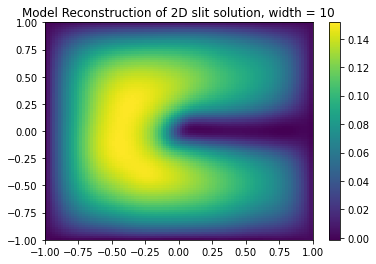

In [ ]:
import array
from jax._src.tree_util import tree_reduce
#plot heatmap
plt.clf()
# params = checkpoint_params
# params = last_cp_params

key,subkey = random.split(key)
num_of_samples = 100
# x_range = np.arange(-1,1,.01) # 2 / 0.01 = 200
x_range = jnp.linspace(-1,1,num=num_of_samples) #inclusive on ijnputs and outputs
# ijnputs = random.choice(subkey,x_range,shape=(500,2),replace=False)
# output = batched_model(params,ijnputs)
# [Xs,Ys] = np.meshgrid(x_range,x_range)
[Xs,Ys] = jnp.meshgrid(x_range,x_range)
# [Xs,Ys] = jnp.meshgrid(x_range)
output = np.zeros(shape=(num_of_samples,num_of_samples))
graph_losses  = np.zeros(shape=(num_of_samples,num_of_samples))
# boundary = np.zeros(shape=(num_of_samples,num_of_samples))

# for i in range(num_of_samples):
#     for j in range(num_of_samples):
#         pointToEval = jnp.array([[Xs[i,j]],[Ys[i,j]]]) #uber naive + slow + L + ratio
#         print(pointToEval)
#         # if j <= 4  i = :
#         #   print(pointToEval)
#         output[i,j] = model(params,pointToEval)
        # output[i,j] = boundary_indicator(pointToEval)
    # ijnputs_wrong_orientation = np.array([Xs[:,i],Ys[:,i]])
    # ijnputs = np.transpose(ijnputs_wrong_orientation)
    # output[:,i] = batched_model(params,ijnputs)
# outputs = batched_model(params,jnp.array([x,y]) for (x,y) in zip(Xs,Ys))
# output = [(model(params,x),model(params,y)) for (x,y) in zip(x_range,x_range)]

for i in range(num_of_samples):
  xRow = Xs[i,:]
  yRow = Ys[i,:]
  # mixed_coords =  np.array([xRow,yRow]) #jnp.concatenate((xRow,yRow))
  # print(f'before reshape: {mixed_coords[99:102]}')
  #vector_to_eval = jnp.reshape(mixed_coords,(2,num_of_samples))
  # vector_to_eval = mixed_coords
  vector_to_eval = jnp.stack((xRow,yRow),axis=1)

  output[i,:] = batched_model(params,vector_to_eval)
  # output[i,:] = bdy_exact_vector(vector_to_eval)
  graph_losses[i,:] = flow_loss_vector(params,vector_to_eval)


# for x in vector_to_eval:
#   output = batched_model(params,x)
#   flows = batched_loss(params,x)
#   boundary = batched_boundary_loss(params,x)
#  # print(f'ijnput: {vector_to_eval[:,:2]}')
#   print(x)

# for i in range(vector_to_eval):
#   output[:,i] = batched_model(params,vector_to_eval)
#   flows[:,i] = batched_loss(params,vector_to_eval)
#   boundary[:,i] = batched_boundary_loss(params,vector_to_eval)
  # print(f'ijnput: {vector_to_eval[:,:2]}')

# print(vector_to_eval.shape)


# plot
# fig, ax = plt.subplots(3,1,sharex=True,sharey=True)
# ax[0].pcolormesh(Xs,Ys,output)
# ax[1].pcolormesh(Xs, Ys, flows)
# ax[2].pcolormesh(Xs, Ys, boundary)

fig, ax = plt.subplots()
graph_output = ax.pcolormesh(Xs,Ys,output)
fig.colorbar(graph_output)
# print(boundary)
plt.title(f'Model Reconstruction of 2D slit solution, width = {hypers["m"]}')
plt.savefig(f'2layer_Jax-2dpoisson-slit-solution-width{hypers["m"]}.png')
plt.show()
# print(flows)



# print(output.shape)

Text(0.5, 1.0, 'Boundary Losses')

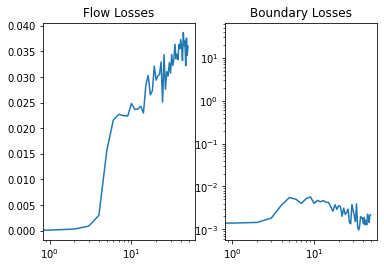

In [ ]:

buffer = [1]*len(training_losses)

# plt.plot(training_losses)
# buffered_list = [a + b for a,b in zip(buffer,training_losses)]
# plt.loglog(buffered_list)
# plt.loglog(training_losses)
# plt.semilogx(training_losses)
# plt.title(f'Loss over slit domain using 1 block, step size {step_size}')
# plt.xlabel("log(epochs)")
# plt.ylabel("log(loss)")
# # plt.savefig("3blocks_box_training_step1e-04_100k_epochs.png")
# plt.show

fig, axs = plt.subplots(nrows=1,ncols=2)
axs[0].semilogx(flow_losses)
axs[0].set_title("Flow Losses")
axs[1].loglog(boundary_losses)
# axs[1].loglog(residuals)
axs[1].set_title("Boundary Losses")
# axs[1].set_title("Model Losses")
# print(f'minimum model error is {jnp.amin(jnp.array(residuals))}')

# plt.savefig(f'2layer_Flow_and_boundary_losses_width={hypers["m"]}.png')

In [ ]:
# params is a list of (w,b) pairs, want to plot them all on a histogram
weights = []
biases = []

for pair in params:
  # print(f'pair: {pair}')
  weights.append(jnp.ravel(pair[0]))
  # biases.append(pair[1])

# w,b = params[3]
# print(w)
# print(f'after ravel: {np.ravel(w)}')
# weights.append(np.ravel(w))
# print(np.array(weights))
# plt.hist(weights)
# plt.hist(biases)
# print(weights)
# plt.hist(jnp.ravel(w))
# plt.hist(b)
# plt.show()

In [ ]:
# plt.savefig(f'Trained_model_box_domain_{num_epochs}_{step_size}.png')